# Submanifold Closure


## Setup

In [1]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from jaxpulse.controllers import *
from jaxpulse.optimizers import *
from jaxpulse.utils import heaviside, rhodot_H
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

### Drift

In [2]:
alpha = .1
beta = .2
delta = .5+.4j
gamma = .1
epsilon = 1.5 + 2j
def c(v):
    return jnp.conj(v)
H_0 = jnp.array(
    [
        [1.0,       alpha,      beta,       0.0,        0.0],
        [c(alpha),  2,          delta,      0.0,        0.0],
        [c(beta),   c(delta),   3,          gamma,      0.0],
        [0.0,       0.0,        c(gamma),   4,          epsilon],
        [0.0,       0.0,        0.0,        c(epsilon), 5]
    ]
)

### Controls

In [3]:
H_1 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_2 = jnp.array(
    [
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [1.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_3 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  1.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_M = [H_1, H_2, H_3]
ppc = [4,4,4,4] # pulse per control
u_M =[
    GaussianControl(
        amp=1.0*jnp.ones((ppc[0],)),
        mean=jnp.linspace(3,9,ppc[0]),
        sigma=jnp.ones((ppc[0],))
    ),
    GaussianControl(
        amp=1.0*jnp.ones((ppc[1],)),
        mean=jnp.linspace(2,10,ppc[1]),
        sigma=1.0*jnp.ones((ppc[1],))
    ),
    GaussianControl(
        amp=1.0*jnp.ones((ppc[2],)),
        mean=jnp.linspace(2,12,ppc[2]),
        sigma=1.0*jnp.ones((ppc[2],))
    )
]
closed_controls = ControlVector(u_M)

v_K = [
    PositiveGaussianControl(
        amp=1.0*jnp.ones((ppc[3],)),
        mean=jnp.linspace(0,15,ppc[3]),
        sigma=jnp.ones((ppc[3],))
    )
]
open_controls = ControlVector(u_M + v_K)

In [4]:
closure_sys = ClosedQuantumSystem(
    H_0=H_0,
    H_M=H_M
)
psi0 = dq.fock(5, 0)
rho0 = dq.todm(psi0)
duration=15

# Exclusion

## State Exclusion
go to 2, avoid 3,4

In [5]:
# project into 3rd
proj = dq.fock_dm(5,2)
def y_final(y: Array) -> float:
    return 1000*(1 - dq.expect(proj, y))

# don't go above 3
exclude_upper = dq.fock_dm(5,3) #+ dq.fock_dm(5,4)
def y_statewise(y: Array, u: Array, t: float) -> float:
    return dq.expect(exclude_upper, y) 

In [6]:
controller = OptimalController(
    system=closure_sys,
    controls=closed_controls,
    y0=psi0,
    duration=duration,
    y_final=y_final,
    y_statewise=y_statewise
)
exp_ops = [dq.number(5),proj]
exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


KeyboardInterrupt: 

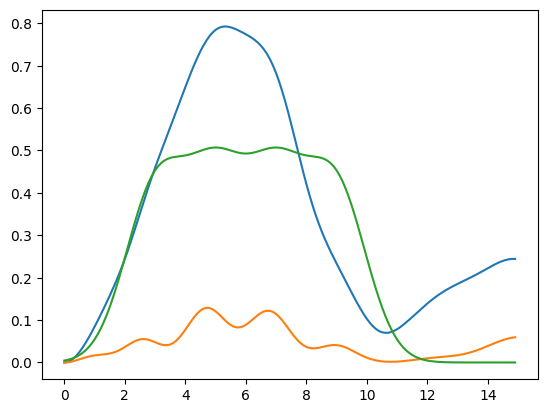

In [7]:
fig_pre, ax_pre = plt.subplots()
controller.plot(ax_pre,
                exp_ops=exp_ops,
                exp_names=exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [ ]:
opt_controller = controller.optimize(
    N_steps=60,
    learning_rate=.1,
    verbosity=1)

In [ ]:
fig_post, ax_post = plt.subplots()
opt_controller.plot(ax_post,
                exp_ops=exp_ops,
                exp_names=exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State")
fig_post.legend()
fig_post.show()

# Manifolds

In [14]:
closure_sys_rho = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[],
    C_K=[]
)
open_closure_sys_rho = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[jnp.sqrt(.1)*dq.create(5)],
    C_K=[jnp.sqrt(.1)*dq.destroy(5)]
)


## Submanfold Stabilization (on $\rho$)
Go to 3, stay in 2,3

In [9]:
# project into 3rd
proj3 = dq.fock_dm(5,2)
def hit3(y: Array) -> float:
    return 1000*(1 - dq.expect(proj3, y))

# don't leave 2,3
hold23 = dq.fock_dm(5,1) + dq.fock_dm(5,2)
def stay23(y: Array, u: Array, t: float) -> float:
    return heaviside(t-5)*(1 - dq.expect(hold23, y))


In [15]:
manifold_controller = OptimalController(
    system=closure_sys_rho,
    controls=closed_controls,
    y0=rho0,
    duration=duration,
    y_final=hit3,
    y_statewise=stay23
)
lossy_manifold_controller = OptimalController(
    system=open_closure_sys_rho,
    controls=open_controls,
    y0=rho0,
    duration=duration,
    y_final=hit3,
    y_statewise=stay23
)
m_exp_ops = [dq.number(5),proj3, hold23]
m_exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$", r"$\langle 2, 3 \rangle$"]

### Pre-Train

In [ ]:
fig_pre, ax_pre = plt.subplots()
manifold_controller.plot(ax_pre,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
fig_pre.legend()
fig_pre.suptitle(r"State Exclusion of $\rho$ for Closed System")
fig_pre.show()


/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_75699/1964844229.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


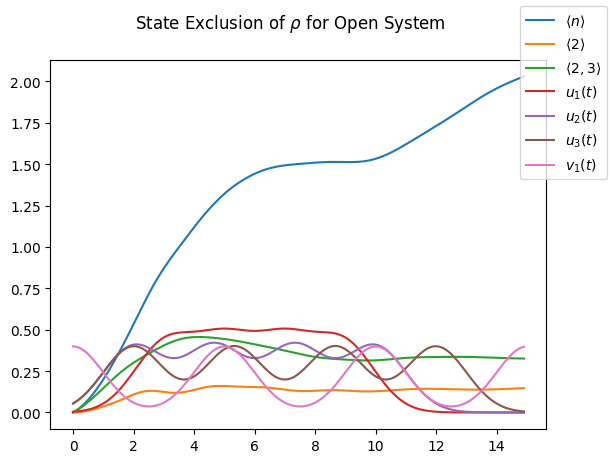

In [16]:
fig_pre, ax_pre = plt.subplots()
lossy_manifold_controller.plot(ax_pre,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
fig_pre.legend()
fig_pre.suptitle(r"State Exclusion of $\rho$ for Open System")
fig_pre.show()

### Train

In [ ]:
opt_manifold_controller = manifold_controller.optimize(
    N_steps=60,
    learning_rate=.1,
    verbosity=1
)

In [ ]:
fig_post, ax_post = plt.subplots()
opt_manifold_controller.plot(ax_post,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State",color='green')
ax_post.hlines(y=[1.0,2.0],xmin=5,xmax=duration,label="Submanifold Band")
fig_post.suptitle(r"State Exclusion of $\rho$ for Closed System")
fig_post.legend()
fig_post.show()

In [17]:
opt_lossy_manifold_controller = lossy_manifold_controller.optimize(
    N_steps=60,
    learning_rate=.1,
    verbosity=2
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.1473675, 1.1473675, 0.8526325, 0.8526325], dtype=float32),
      mean=Array([3.1473675, 4.8526325, 6.8526325, 9.1473675], dtype=float32),
      sigma=Array([0.8526326, 0.8526325, 1.1473675, 0.8526326], dtype=float32)
    ),
    GaussianControl(
      amp=Array([1.1473675, 0.8526326, 0.8526326, 1.1473675], dtype=float32),
      mean=Array([ 2.1473675,  4.5192995,  7.480701 , 10.1473675], dtype=float32),
      sigma=Array([1.1473675, 0.8526326, 1.1473675, 0.8526325], dtype=float32)
    ),
    GaussianControl(
      amp=Array([0.8526326, 0.8526325, 0.8526325, 1.1473675], dtype=float32),
      mean=Array([ 2.1473675,  5.4807005,  8.5192995, 12.1473675], dtype=float32),
      sigma=Array([0.8526325, 1.1473675, 1.1473675, 0.8526326], dtype=float32)
    ),
    PositiveGaussianControl(
      amp=Array([-1.1473674, -1.1473675, -1.1473675, -1.1473675], dtype=float32),
      mean=Array([ 0.1473674,  5.1473675, 10.1473675, 14.8526325], 

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_75699/1944876570.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


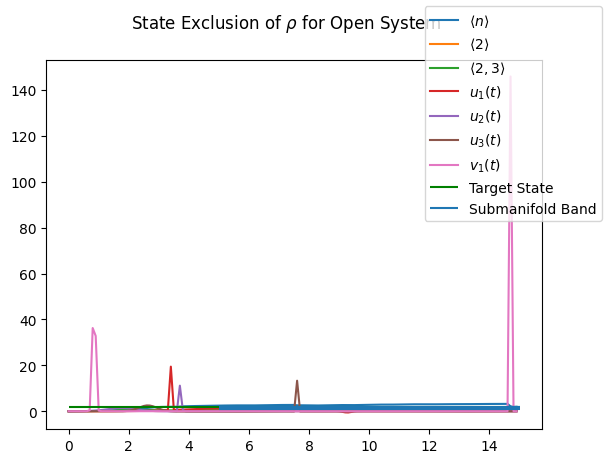

In [18]:
fig_post, ax_post = plt.subplots()
opt_lossy_manifold_controller.plot(ax_post,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State",color='green')
ax_post.hlines(y=[1.0,2.0],xmin=5,xmax=duration,label="Submanifold Band")
fig_post.suptitle(r"State Exclusion of $\rho$ for Open System")
fig_post.legend()
fig_post.show()

## Submanifold Stabilization (on $\dot{\rho}$, closed)

In [ ]:
U = jnp.array(
    [
        [0.0, 0.0],
        [1.0, 0.0],
        [0.0, 1.0],
        [0.0, 0.0],
        [0.0, 0.0]
    ], dtype=complex
)
U_dag = dq.dag(U)

# don't leave 2,3
def her0_proj(sigmadot: Array): 
    return .5*(
        dq.sigmax() * dq.trace(dq.sigmax() @ sigmadot) + 
        dq.sigmay() * dq.trace(dq.sigmay() @ sigmadot) + 
        dq.sigmaz() * dq.trace(dq.sigmaz() @ sigmadot)    
    )

def Pidot(rhodot):
    return U @ her0_proj(U_dag @ rhodot @ U) @ U_dag

hold23 = U @ U_dag
def exit23(y: Array, u: Array, t: float) -> float:
    # build rhodot
    H_tot = H_0
    for u_m, H_m in zip(u, H_M):
        H_tot = H_tot + H_m*u_m
    rhodot = rhodot_H(H_tot,y)
    # find elements exiting space
    rhodot_perp = rhodot - Pidot(rhodot)
    return heaviside(t-5)*jnp.trace(rhodot_perp @ rhodot_perp)

In [ ]:
manifold_exit_controller = OptimalController(
    system=closure_sys_rho,
    controls=closed_controls,
    y0=rho0,
    duration=duration,
    y_final=hit3,
    y_statewise=exit23
)
lossy_manifold_exit_controller = OptimalController(
    system=open_closure_sys_rho,
    controls=open_controls,
    y0=rho0,
    duration=duration,
    y_hit=hit3,
    y_statewise=exit23,
)
m_exp_ops = [dq.number(5),proj3, hold23]
m_exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$", r"$\langle 2, 3 \rangle$"]

### Pre-Train

In [ ]:
fig_pre, ax_pre = plt.subplots()
manifold_exit_controller.plot(ax_pre,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
fig_pre.legend()
fig_pre.show()

In [ ]:
opt_manifold_exit_controller = manifold_exit_controller.optimize(
    N_steps=60,
    learning_rate=.1,
    verbosity=1
)

In [ ]:
fig_post, ax_post = plt.subplots()
opt_manifold_exit_controller.plot(ax_post,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State",color='green')
ax_post.hlines(y=[1.0,2.0],xmin=5,xmax=duration,label="Submanifold Band")
fig_post.legend()
fig_post.show()

## Submanifold stabilization (on $\dot{\rho}$, open)